# EB Fields
author: Louis Richard\
Plots E and B time series and of burst mode electric field in GSE coordinates and field-aligned coordinates. Plots spectrograms of paralleland perpendicular electric fields and fluctuating magnetic field.

In [1]:
import time

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from pyrfu import mms, pyrf
from pyrfu.plot import plot_line, plot_spectr

Load IGRF coefficients ...


## Define time interval, data path and spacecraft index

In [2]:
mms.db_init("/Volumes/mms")

tint = ["2015-10-30T05:15:20.000", "2015-10-30T05:16:20.000"]
ic = 1

## Load data

### Load FGM data

In [4]:
b_xyz = mms.get_data("b_gse_fgm_brst_l2", tint, ic)
b_mag = pyrf.norm(b_xyz)

21-Apr-23 12:16:55: Loading mms1_fgm_b_gse_brst_l2...


### Load EDP data

In [5]:
e_xyz = mms.get_data("e_gse_edp_brst_l2", tint, ic)

21-Apr-23 12:16:55: Loading mms1_edp_dce_gse_brst_l2...


### Load SCM data

In [6]:
b_scm = mms.get_data("b_gse_scm_brst_l2", tint, ic)

21-Apr-23 12:16:57: Loading mms1_scm_acb_gse_scb_brst_l2...


### Load FPI data

In [7]:
n_e =  mms.get_data("ne_fpi_brst_l2", tint, ic)

21-Apr-23 12:16:59: Loading mms1_des_numberdensity_brst...
21-Apr-23 12:16:59: /opt/anaconda3/lib/python3.8/site-packages/pyrfu/mms/get_ts.py:64: UserWarning: Epoch_plus_var/Epoch_minus_var units are not clear, assume s
  warnings.warn(message)



## Compute low and high frequency electric field and magnetic field fluctuations in FAC

### Rotate E and B into field-aligned coordinates

In [8]:
e_fac = pyrf.convert_fac(e_xyz, b_xyz,[1, 0, 0])
b_fac = pyrf.convert_fac(b_scm, b_xyz,[1, 0, 0])

#### Bandpass filter E and B waveforms

In [9]:
fmin, fmax = [.5, 1000]  # Hz
e_fac_hf = pyrf.filt(e_fac, fmin, 0, 3)
e_fac_lf = pyrf.filt(e_fac, 0, fmin, 3)
b_fac_hf = pyrf.filt(b_fac, fmin, 0, 3)

## Wavelet transform of the electric field and the magnetic field fluctuations

### Compute wavelet transforms

In [ ]:
nf = 100
start = time.time()
e_cwt = pyrf.wavelet(e_fac, f_range=[fmin, fmax], n_freqs=nf)
print(time.time() - start)
#b_cwt = pyrf.wavelet(b_scm, f_range=[fmin, fmax], n_freqs=nf)

> /opt/anaconda3/lib/python3.8/site-packages/pyrfu/pyrf/wavelet.py(170)wavelet()
    168         # Calculate the FFT of the wavelet transform
    169         pdb.set_trace()
--> 170         w_w = _ww(s_w_mat, scales_mat, sigma, frequencies_mat, f_nyq)
    171 
    172         # Backward FFT



### Compress wavelet transform

In [10]:
nc = 100

# Number of frequencies
nf = e_cwt.x.shape[1]

idxs = np.arange(int(nc / 2), len(e_cwt.time) - int(nc / 2), step=nc).astype(int)

e_cwt_times = e_cwt.time[idxs]

e_cwt_x, e_cwt_y, e_cwt_z = [np.zeros((len(idxs), nf)) for _ in range(3)]

for i, idx in enumerate(idxs):
    e_cwt_x[i, :] = np.squeeze(np.nanmean(e_cwt.x[idx - int(nc / 2) + 1:idx + int(nc / 2), :], axis=0))
    e_cwt_y[i, :] = np.squeeze(np.nanmean(e_cwt.y[idx - int(nc / 2) + 1:idx + int(nc / 2), :], axis=0))
    e_cwt_z[i, :] = np.squeeze(np.nanmean(e_cwt.z[idx - int(nc / 2) + 1:idx + int(nc / 2), :], axis=0))

options = dict(coords=[e_cwt_times, e_cwt.frequency], dims=["time", "frequency"])
e_perp_cwt = xr.DataArray(e_cwt_x + e_cwt_y, **options)
e_para_cwt = xr.DataArray(e_cwt_z, **options)

# Number of frequencies
nf = b_cwt.x.shape[1]

idxs = np.arange(int(nc / 2), len(b_cwt.time) - int(nc / 2), step=nc).astype(int)

b_cwt_times = b_cwt.time[idxs]

b_cwt_x, b_cwt_y, b_cwt_z = [np.zeros((len(idxs), nf)) for _ in range(3)]

for i, idx in enumerate(idxs):
    b_cwt_x[i, :] = np.squeeze(np.nanmean(b_cwt.x[idx - int(nc / 2) + 1:idx + int(nc / 2), :], axis=0))
    b_cwt_y[i, :] = np.squeeze(np.nanmean(b_cwt.y[idx - int(nc / 2) + 1:idx + int(nc / 2), :], axis=0))
    b_cwt_z[i, :] = np.squeeze(np.nanmean(b_cwt.z[idx - int(nc / 2) + 1:idx + int(nc / 2), :], axis=0))

options = dict(coords=[b_cwt_times, b_cwt.frequency], dims=["time", "frequency"])
b_cwt = xr.DataArray(b_cwt_x + b_cwt_y + b_cwt_z, **options)

09-Dec-21 11:06:18: <ipython-input-10-7f0a7a5b79a0>:13: RuntimeWarning: Mean of empty slice
  e_cwt_x[i, :] = np.squeeze(np.nanmean(e_cwt.x[idx - int(nc / 2) + 1:idx + int(nc / 2), :], axis=0))

09-Dec-21 11:06:18: <ipython-input-10-7f0a7a5b79a0>:14: RuntimeWarning: Mean of empty slice
  e_cwt_y[i, :] = np.squeeze(np.nanmean(e_cwt.y[idx - int(nc / 2) + 1:idx + int(nc / 2), :], axis=0))

09-Dec-21 11:06:18: <ipython-input-10-7f0a7a5b79a0>:15: RuntimeWarning: Mean of empty slice
  e_cwt_z[i, :] = np.squeeze(np.nanmean(e_cwt.z[idx - int(nc / 2) + 1:idx + int(nc / 2), :], axis=0))

09-Dec-21 11:06:25: <ipython-input-10-7f0a7a5b79a0>:31: RuntimeWarning: Mean of empty slice
  b_cwt_x[i, :] = np.squeeze(np.nanmean(b_cwt.x[idx - int(nc / 2) + 1:idx + int(nc / 2), :], axis=0))

09-Dec-21 11:06:25: <ipython-input-10-7f0a7a5b79a0>:32: RuntimeWarning: Mean of empty slice
  b_cwt_y[i, :] = np.squeeze(np.nanmean(b_cwt.y[idx - int(nc / 2) + 1:idx + int(nc / 2), :], axis=0))

09-Dec-21 11:06:25: <ipyt

## Compute characteristic frequencies

In [11]:
me = constants.m_e.value
mp = constants.m_p.value
qe = constants.e.value
eps0 = constants.eps0.value
mu0 = constants.mu0.value
mp_me = mp / me
b_si = b_mag * 1e-9
w_pe = np.sqrt(resample(n_e, b_xyz) * 1e6 * qe ** 2 /(me * eps0))
w_ce = qe * b_si / me
w_pp = np.sqrt(resample(n_e, b_xyz) * 1e6 * qe ** 2/ (mp * eps0))
f_ce = w_ce / (2 * np.pi)
f_pe = w_pe / (2 * np.pi)
f_cp = f_ce / mp_me
f_pp = w_pp / (2 * np.pi)
f_lh = np.sqrt(f_cp * f_ce /(1 + f_ce ** 2. / f_pe ** 2) + f_cp ** 2)

## Plot figure

In [12]:
legend_options = dict(ncol=4, loc="upper right", frameon=True)
spectr_options = dict(yscale="log", cscale="log", cmap="Spectral_r")

<IPython.core.display.Javascript object>


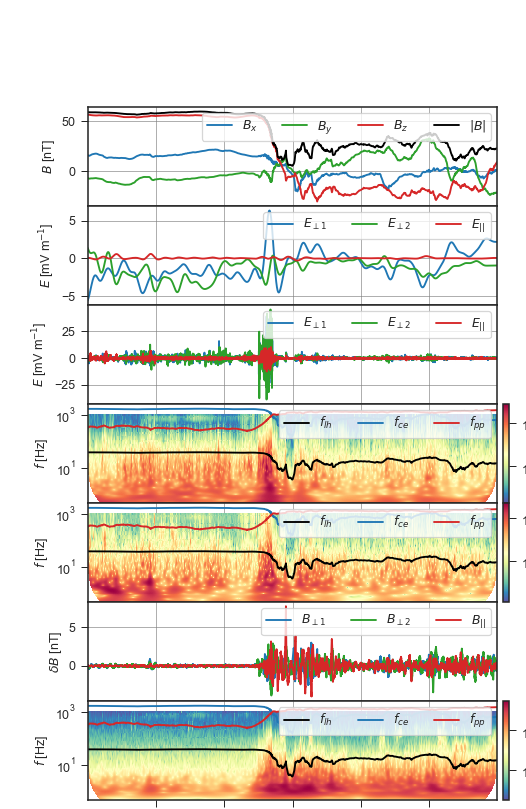

In [13]:
%matplotlib notebook
f, axs = plt.subplots(7, sharex="all", figsize=(6.5, 10))
f.subplots_adjust(hspace=0, left=.15, right=.85)

plot_line(axs[0], b_xyz)
plot_line(axs[0], b_mag)
axs[0].set_ylabel("$B$ [nT]")
labels = ["$B_x$", "$B_y$", "$B_z$", "$|B|$"]
axs[0].legend(labels, **legend_options)

plot_line(axs[1], e_xyzfac_lf)
axs[1].set_ylabel("$E$ [mV m$^{-1}$]")
labels = ["$E_{\\perp 1}$", "$E_{\\perp 2}$", "$E_{||}$"]
axs[1].legend(labels, **legend_options)

plot_line(axs[2], e_xyzfac_hf)
axs[2].set_ylabel("$E$ [mV m$^{-1}$]")
labels = ["$E_{\\perp 1}$", "$E_{\\perp 2}$", "$E_{||}$"]
axs[2].legend(labels, **legend_options)

axs[3], caxs3 = plot_spectr(axs[3], e_perp_cwt, **spectr_options)
axs[3].set_ylabel("$f$ [Hz]")
caxs3.set_ylabel("$E_{\\perp}^2$" + "\n" + "[mV$^{2}$ m$^{-2}$ Hz$^{-1}$]")
plot_line(axs[3], f_lh, color="k")
plot_line(axs[3], f_ce, color="tab:blue")
plot_line(axs[3], f_pp, color="tab:red")
labels = ["$f_{lh}$", "$f_{ce}$", "$f_{pp}$"]
axs[3].legend(labels, **legend_options)

axs[4], caxs4 = plot_spectr(axs[4], e_para_cwt, **spectr_options)
axs[4].set_ylabel("$f$ [Hz]")
caxs4.set_ylabel("$E_{||}^2$" + "\n" + "[mV$^{2}$ m$^{-2}$ Hz$^{-1}$]")
plot_line(axs[4], f_lh, color="k")
plot_line(axs[4], f_ce, color="tab:blue")
plot_line(axs[4], f_pp, color="tab:red")
labels = ["$f_{lh}$", "$f_{ce}$", "$f_{pp}$"]
axs[4].legend(labels, **legend_options)

plot_line(axs[5], b_scmfac_hf)
axs[5].set_ylabel("$\\delta B$ [nT]")
labels = ["$B_{\\perp 1}$", "$B_{\\perp 2}$", "$B_{||}$"]
axs[5].legend(labels, **legend_options)

axs[6], caxs6 = plot_spectr(axs[6], b_cwt, **spectr_options)
axs[6].set_ylabel("$f$ [Hz]")
caxs6.set_ylabel("$B^2$" + "\n" + "[nT$^{2}$ Hz$^{-1}$]")
plot_line(axs[6], f_lh, color="k")
plot_line(axs[6], f_ce, color="tab:blue")
plot_line(axs[6], f_pp, color="tab:red")
labels = ["$f_{lh}$", "$f_{ce}$", "$f_{pp}$"]
axs[6].legend(labels, **legend_options)